In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from IPython.display import clear_output
%config NotebookApp.iopub_msg_rate_limit=10000
import time

In [2]:
movies = pd.read_json("movies.json")
reviews = pd.read_json("reviews.json")

In [3]:
movies.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [4]:
reviews = reviews.drop(['timestamp'], axis=1)
reviews.head()

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


In [5]:
len(movies)

1682

In [6]:
len(reviews['user_id'].unique())

942

In [30]:
def findModes(lst, n):
    counter = Counter(lst)
    modes = counter.most_common(n)
    return [mode[0] for mode in modes]

In [8]:
#Finding the best number of top rated movies to use

def findNumMovies(df, numModes, total):
    modes = findModes(df['item_id'], numModes)
    filteredDF = df[df['item_id'].isin(modes)].reset_index(drop=True)
    pivotDF = filteredDF.pivot(index='user_id', columns='item_id', values='rating')
    pivotDF.fillna(-1, inplace=True)
    scores = {}
    clusters = len(pivotDF)
    for i in range(2, clusters):
        agg = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
        agg = agg.fit(pivotDF)
        ss_avg = silhouette_score(pivotDF, agg.labels_)
        scores[i] = ss_avg
        percentDone = round(((((i-1)/(clusters-1))/(total))+((numModes-2)/total))*100,2)
        clear_output(wait=True)
        time.sleep(0.001)
        print(str(percentDone) + "% done")
    bestScore = scores[max(scores, key=scores.get)]
    return bestScore

In [9]:
bestScores = {}
topRange = 10
for i in range(2, topRange+1):
    bestScore = findNumMovies(reviews, i, topRange-1)
    bestScores[i] = bestScore

99.99% done


In [10]:
bestScores

{2: 0.9951028972507443,
 3: 0.963519130654862,
 4: 0.8682041294090866,
 5: 0.6975863849107319,
 6: 0.5057191895626062,
 7: 0.38872554457572944,
 8: 0.3714994475144047,
 9: 0.3403318073180625,
 10: 0.30119573804609995}

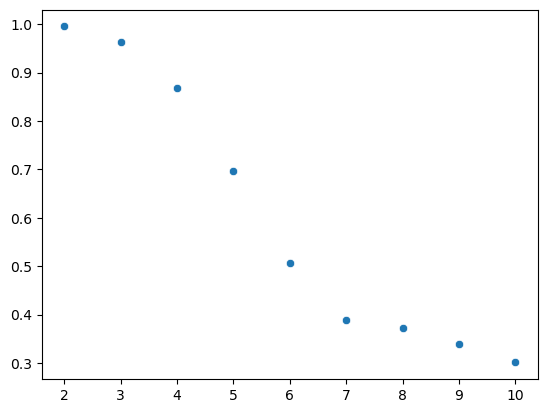

In [11]:
#3 seems to be the best elbow point for top movies
sns.scatterplot(x=bestScores.keys(), y=bestScores.values()) #30 is the optimal number of clusters
plt.show()

In [12]:
numTopMovies = 3

In [13]:
modes = findModes(reviews['item_id'], numTopMovies)
print(modes)

[50, 258]


In [14]:
filteredReviews = reviews[reviews['item_id'].isin(modes)].copy().reset_index(drop=True)

In [15]:
filteredReviews.head()

,user_id,item_id,rating
0,0,50,5
1,26,258,3
2,66,258,4
3,207,258,4
4,290,50,5


In [16]:
pivotDF = filteredReviews.pivot(index='user_id', columns='item_id', values='rating')
pivotDF.fillna(-1, inplace=True)
pivotDF.head()

item_id,50,258
user_id,,
0,5.0,-1.0
1,5.0,5.0
2,5.0,3.0
3,-1.0,2.0
4,5.0,5.0


In [17]:
scores = {}
clusters = len(pivotDF)
for i in range(2, clusters):
    agg = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    agg = agg.fit(pivotDF)
    ss_avg = silhouette_score(pivotDF, agg.labels_)
    scores[i] = ss_avg

30


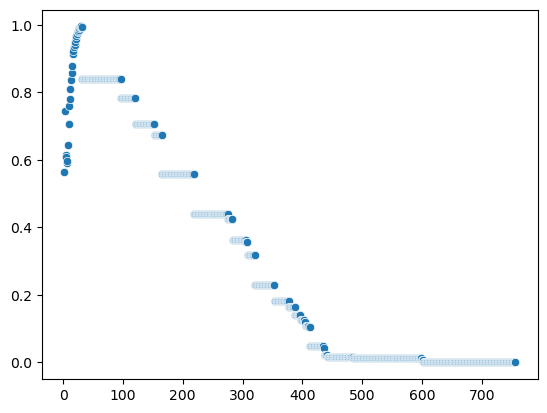

In [18]:
sns.scatterplot(x=scores.keys(), y=scores.values()) #30 is the optimal number of clusters
bestClusters = max(scores, key=scores.get)
print(bestClusters)

In [19]:
agg = AgglomerativeClustering(n_clusters=bestClusters, affinity='euclidean', linkage='ward')
agg = agg.fit(pivotDF)

In [20]:
pivotDF["cluster"] = agg.labels_
pivotDF.reset_index(inplace=True)
pivotDF.head()

item_id,user_id,50,258,cluster
0,0,5.0,-1.0,1
1,1,5.0,5.0,3
2,2,5.0,3.0,9
3,3,-1.0,2.0,20
4,4,5.0,5.0,3


In [21]:
pivotDF.loc[pivotDF.loc[:,'user_id'] == 491]

item_id,user_id,50,258,cluster
404,491,-1.0,4.0,5


In [22]:
pivotDF.loc[pivotDF.loc[:,'cluster'] == 5]

item_id,user_id,50,258,cluster
17,19,-1.0,4.0,5
22,24,-1.0,4.0,5
29,33,-1.0,4.0,5
32,39,-1.0,4.0,5
40,47,-1.0,4.0,5
...,...,...,...,...
704,877,-1.0,4.0,5
738,920,-1.0,4.0,5
743,926,-1.0,4.0,5
752,939,-1.0,4.0,5


In [23]:
clusterUsers = pivotDF.loc[pivotDF.loc[:,'cluster'] == 5]['user_id'].unique()
recomendDF = reviews.loc[reviews['user_id'].isin(clusterUsers)].reset_index(drop=True)
moviesSeen = recomendDF.loc[recomendDF.loc[:,'user_id'] == 491]['item_id'].unique()
recomendDF = recomendDF[~recomendDF['item_id'].isin(moviesSeen)].reset_index(drop=True)
recomendDF = recomendDF.pivot(index='user_id', columns='item_id', values='rating')
recomendDF.head()

item_id,1,2,3,4,5,8,9,10,11,13,...,1504,1518,1524,1529,1591,1602,1612,1617,1624,1625
user_id,,,,,,,,,,,,,,,,,,,,,
19,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
item_means = pd.DataFrame(recomendDF.mean(axis=0))
item_means

,0
item_id,
1,3.500000
2,3.000000
3,2.000000
4,3.250000
5,2.666667
...,...
1602,4.000000
1612,4.000000
1617,1.000000


In [25]:
item_means.idxmax()


0    57
dtype: int64

In [36]:
movies.loc[movies.loc[:,'item_id'] == 57]

,item_id,title
56,57,Priest (1994)


In [37]:
item_means.iloc[57]

0    3.333333
Name: 77, dtype: float64